<a href="https://colab.research.google.com/github/pdrobny/MonReader/blob/main/P4_PaulNet_WnB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import tensorflow as tf
import random
import wandb
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, AvgPool2D, Conv2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['flip', 'not flip']); ax.yaxis.set_ticklabels(['flip', 'not flip'])
    plt.show()

In [3]:
# load files from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
class PaulNet:
      def __init__(self, optimizer, num_epochs, batch, pooling_type):
        self.optimizer = optimizer # examples: 'adam', 'sgb', 'lion
        self.num_epochs = num_epochs
        self.batch = batch # examples:  32, 64, 128
        self.pooling_type = pooling_type # 'max' for MaxPooling2D, 'avg' for AvgPool2D

      def pageflip(self):
        #define configuration options
        img_rows, img_cols = 150, 150
        batch_size = self.batch
        n_epochs = 5
        n_classes = 2
        val_split = 0.2
        verbosity = 1
        path = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/training'
        path_test = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/testing'
        input_shape = (img_rows, img_cols, 3)
        labels = ['flip', 'notflip']
        seed = 42

        # Data generators
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=val_split,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )

        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

        test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            directory = path,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = False,
            target_size=(img_rows, img_cols),
            subset = 'training'
        )

        val_generator = val_datagen.flow_from_directory(
            directory = path,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = False,
            target_size=(img_rows, img_cols),
            subset = 'validation'
        )

        test_generator = test_datagen.flow_from_directory(
            directory = path_test,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = True,
            target_size=(img_rows, img_cols)
        )
        print("Train classes:", train_generator.class_indices)

        # Choose pooling layer based on self.pooling_type
        if self.pooling_type == 'max':
          pooling_layer = MaxPooling2D(pool_size=(2, 2))
        elif self.pooling_type == 'avg':
          pooling_layer = AvgPool2D(pool_size=(2, 2))
        else:
          raise ValueError("pooling_type must be 'max' or 'avg'")

        # Compute class weights
        y_train = train_generator.classes
        class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = dict(enumerate(class_weights_array))
        print("Class weights:", class_weight)

        # Model architecture
        model = models.Sequential([
            layers.Input(shape=(img_rows, img_cols, 3)),

            layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(1, activation='sigmoid')  # Binary classification
        ])

        # print the summary of the model
        print(model.summary())

        # compile model
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])  #choose optimizer 'adam', 'sgd', or 'lion'

           # Callbacks to reduce overfitting
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
        ]

        # Train the model
        flip_model = model.fit(train_generator,
                                      steps_per_epoch=train_generator.samples // batch_size,
                                      epochs=self.num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=val_generator.samples // batch_size,
                                      class_weight=class_weight,
                                      callbacks=callbacks,
                                      verbose=1)
         # Predict on test set
        y_true = test_generator.classes
        y_pred_probs = model.predict(test_generator)

        # Find best threshold
        #best_thresh, best_f1 = 0.5, 0
       # for thresh in np.arange(0.1, 0.9, 0.01):
            #y_pred_bin = (y_pred_probs > thresh).astype(int)
            #f1 = f1_score(y_true, y_pred_bin)
            #if f1 > best_f1:
               # best_f1 = f1
                #best_thresh = thresh

        # Final predictions
        #y_pred = (y_pred_probs > best_thresh).astype(int).flatten()
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        #print(f"\n🔍 Best Threshold: {best_thresh:.2f}")
        #print(f"✅ F1 Score: {best_f1:.4f}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
        plot_confusion_matrix(y_true, y_pred)

        return model, flip_model, test_generator

      def flip_test(self):
        # plot loss curves
          history = flip_model
          plt.figure(figsize=(5, 5))
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.title('Loss Curve')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend()
          plt.show()

          #plot accuracy curves
          plt.figure(figsize=(5, 5))
          plt.plot(history.history['accuracy'], label='Training Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.title('Accuracy Curve')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.show()

          # Predict on new data (example)
          sample_images, sample_labels = next(test_generator)
          predictions = model.predict(sample_images)
          predicted_classes = (predictions > 0.5).astype(int)
          y_true = sample_labels
          class_names = list(test_generator.class_indices.keys())
          # Show some predicted images
          for i in range(5):
              plt.imshow(sample_images[i])
              true_label = class_names[int(sample_labels[i])]
              predicted_label = 'flip' if predicted_classes[i][0] == 0 else 'notflip'
              plt.title(f"Actual: {true_label}, Predicted: {predicted_label}")
              plt.axis('off')
              plt.show()

          # Generate the classification report
          print(classification_report(y_true, predicted_classes, target_names=class_names))
          # plot confusion matrix
          plot_confusion_matrix(y_true, predicted_classes)


In [7]:
os.environ["WANDB_API_KEY"] = "WANDB" # Replace with your actual API key
wandb.login()

True

Found 1238 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Train classes: {'flip': 0, 'notflip': 1}
Class weights: {0: np.float64(0.6655913978494624), 1: np.float64(2.00974025974026)}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,377 (40.58 MB)

 Trainable params: 10,636,929 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.4932 - loss: 1.3540 - val_accuracy: 0.1944 - val_loss: 1.1243 - learning_rate: 0.0100
Epoch 2/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.4688 - loss: 0.8474

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.4688 - loss: 0.8474 - val_accuracy: 0.1944 - val_loss: 1.1420 - learning_rate: 0.0100
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.4922 - loss: 1.2025 - val_accuracy: 0.2465 - val_loss: 1.1011 - learning_rate: 0.0100
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.4688 - loss: 2.0135 - val_accuracy: 0.2014 - val_loss: 1.1240 - learning_rate: 0.0100
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5052 - loss: 1.1329 - val_accuracy: 0.2674 - val_loss: 1.1888 - learning_rate: 0.0100
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 877ms/step

Classification Report:
               precision    recall  f1-score   support

        flip       0.55      0.22      0.32       290
     notflip       0.53      0.83      0.65       307

    accuracy                           0.53       597
   macro avg       0.54      0.53      0.48       597
weighted avg       0.54      0.53      0.49       597



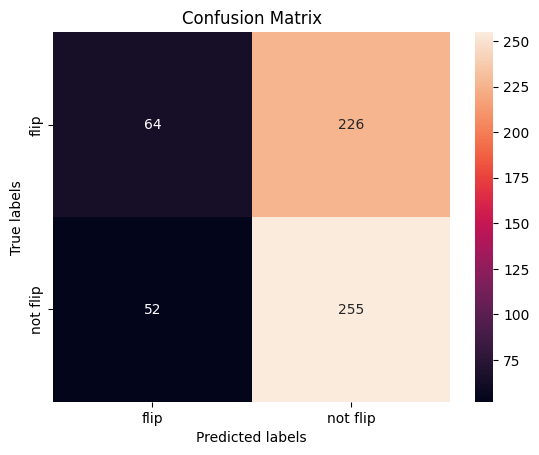

accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.50498
loss,1.09186
val_accuracy,0.26736
val_loss,1.18881


In [15]:
#select attribute values
optimizer = 'sgd' # examples: 'adam', 'sgd', 'lion
num_epochs = 5 # examples:5, 10, 15
batch = 32 # examples:  32, 64, 128
pooling_type = 'max' # 'max' for MaxPooling2D, 'avg' for AvgPool2D

# Start a new wandb run to track this script.
run = wandb.init(
    project='custom model',
    notes='sgd, accuracy',
    config={
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'batch': batch,
        'pooling_type': pooling_type
    }
)


#pass selected attributes to new object
build = PaulNet(optimizer, num_epochs, batch, pooling_type)

# run the pageflip flip method on build object
model, flip_model, test_generator = build.pageflip()

# log metrics
wandb.log({'accuracy': flip_model.history['accuracy'][-1]})
wandb.log({'loss': flip_model.history['loss'][-1]})
wandb.log({'val_accuracy': flip_model.history['val_accuracy'][-1]})
wandb.log({'val_loss': flip_model.history['val_loss'][-1]})

# Finish the run
wandb.finish()

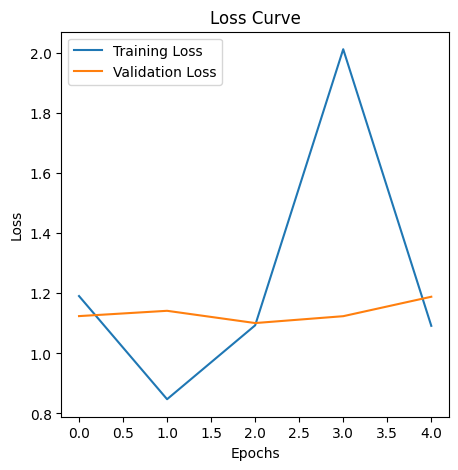

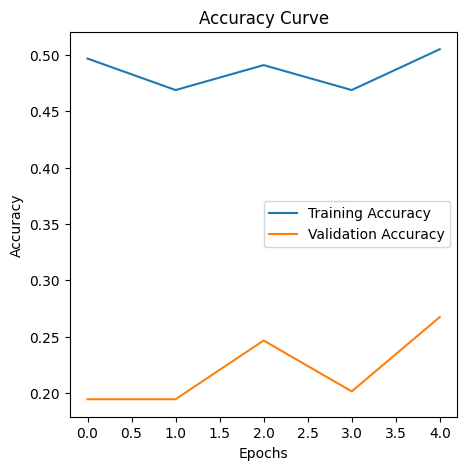

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


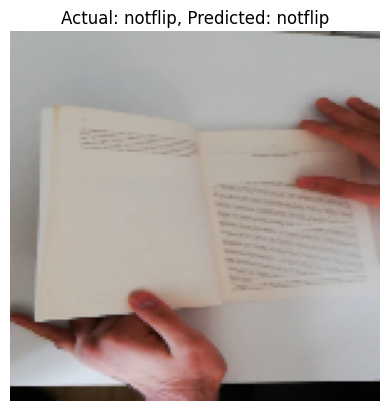

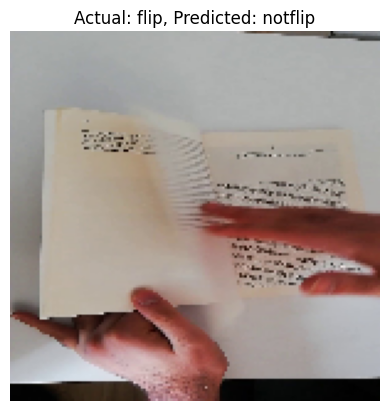

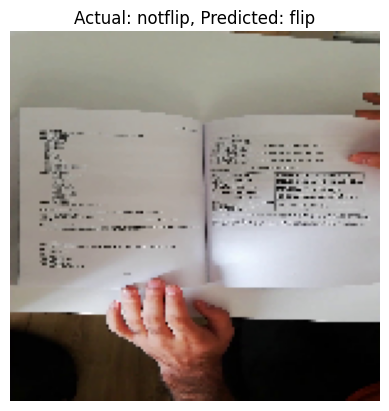

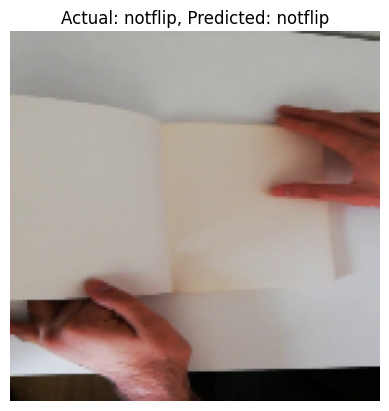

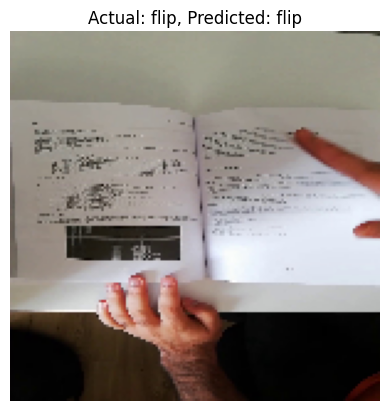

              precision    recall  f1-score   support

        flip       0.30      0.20      0.24        15
     notflip       0.45      0.59      0.51        17

    accuracy                           0.41        32
   macro avg       0.38      0.39      0.38        32
weighted avg       0.38      0.41      0.38        32



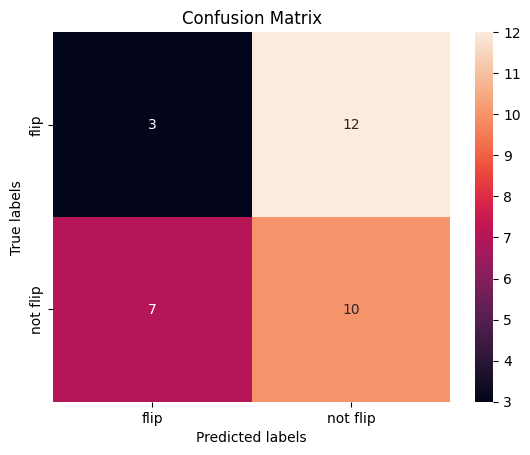

In [16]:
build.flip_test()